# 1. Initializations and Dataset Download

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  harshitwadichar


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|███████████████████████████████████████████████████████████████████████████████| 3.30M/3.30M [00:01<00:00, 1.83MB/s]

# 2. Imports
Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with ```mps```.


In [7]:
pip install --upgrade ipywidgets

   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ---------------------------------- ----- 786.4/914.9 kB 5.6 MB/s eta 0:00:01
   ---------------------------------- ----- 786.4/914.9 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 914.9/914.9 kB 1.5 MB/s  0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.2 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 6.2 MB/s  0:00:00

   ------------- -------------------------- 1/3 [jupyterlab_widgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- --------

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Available Device is: ", device)

Available Device is:  cuda


# 2. Dataset
Now lets read the dataset, this lab was developed by Google Colab, so dataset downloaded and read from the path shown below. We will be reading the dataset using pandas `read_json` function, then we will remove the nulls/missing data from our dataframe as a filteration process, keep in mind that this process is essential as missing data will stop the code from training. You can skip dropping the missing values if you are 100% sure that there are no missing values in your data. After that we printed the dataset shape and we used the `head()` function to visualize the first 5 rows, this step is optional as it just allows us to see the first 5 rows and will not affect the training process.

In [2]:
data_df = pd.read_json("news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_df.dropna(inplace=True)
print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# 3. Data Splitting
Now we will split our data into the following:

*   Training Size 70%
*   Validation Size 15%
*   Testing Size 15%

We will do this by splitting our data twice using the `train_test_split` function in `sklearn` the function takes inputs, outputs and the testing size. After that we will print the training, validation and testing shapes and sizes.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [4]:
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is:  18696  rows which is  70.0 %
Validation set is:  4006  rows which is  15.0 %
Testing set is:  4007  rows which is  15.0 %


# 4. Download Model and tokenizer
In the next cell, we will download the model `bert-base-uncased` and its tokenizer using the function `from_pretrained`. Make sure that if you use any model on huggingface or any transformer or pretrained model, use its own tokenizer, if you use any tokenizer with any model the results will be very bad as it wasn't designed for that model.



In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

# 5. Dataset Object
Now we will create the dataset object. This part is not complex but its a bit tricky. We need to convert our dataset to PyTorch `Dataset` object as it will be more efficient during training, you can use the dataset as its, but lets keep things professional and efficient. First we define our class that will be taking the main `Dataset` class with the concept of inheritance. Let's make the concept simpler. There is a big class that PyTorch, this class has several functions inside it, we will recreate that class and modify some functions to match our needs.

In the cell below, we rebuilt the `constructor` function which is `__init__`. We put `X` and `Y` as a parameters to this function which are the inputs and outputs respectively, then inside the function we define the tokenized inputs using the tokenizer function and converting the outputs to tensors. Additionally, we moved all our data to cuda device. Keep in mind that we set `return_tensors` as `pt` which means return pytorch tensors, other option would be `tf` which is tensorflow tensors. Most of the existing transformers now don't support tensorflow. Then we modified the `__len__` and the `__getitem__` to match our needs which gets the specific length/shape of the data, and the data of specific row in our data respectively.

In [15]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = [tokenizer(x,
                            max_length = 100,
                            truncation = True,
                            padding = 'max_length',
                            return_tensors='pt').to(device)
                  for x in X
                 ]

        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

# 6. Training Hyper Parameters
Now we are setting the training hyperparameters, we defined some variables which are the batch size, number of training epochs and learning rate.

In [16]:
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4

# 7. Data Loaders
This concept may seem complicated, but its very easy, PyTorch provides a class called `DataLoader` which allows us to create objects of it to simplify the training.

`Dataloader` is an object that we can loop through it to train according to batches. When we start training, we loop through epochs, if you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most of the cases you need to train through using batches. `Dataloader` allows you to loop through the batches easily during the training. When you create a dataloader. You define the batch size and enable the shuffle to randomize the data and then you can loop through it in each epoch to train normally.

In the next cell, we defined a dataloader for each of our data (training, validation and testing).

In [17]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

# 8. Model Class
Creating a model in PyTorch seems not very straight forward in the beggining, but if you understand how machine learning and deep learning works, it will be easy for you to understand PyTorch structure easily.

In the next cell we define a new class `MyModel` that inherits from `nn.Module` like we did for the dataset. Remember, in simple terms, we want to redefine some functions in the class to match our needs. In the constructor which is `__init__` and we give it the bert model. Then `super(MyModel, self).__init__()` This line calls the constructor of the parent class `nn.Module` to ensure it's properly initialized. Which means we have the original constructor together with our part of it!

Then, we create our layers, we will have in addition to bert layers a dropout layer, 2 linear (dense) layers and a sigmoid activation function since we are dealing with Binary Classification Problem. Keep in mind that we have to mention for each layer the number of inputs and outputs except for the dropout layer. Linear 2 in this case is the output layer without the activation.

In the function forward, this function is the forward propagation of the model, how is the data flowing inside the model from the input to the output. This means we can control this completely. That's how PyTorch is so customizable! In the below cell, we define the flow as follows, starting by Bert followed by a linear layer then dropout, another linear and finally the sigmoid.

In [12]:
class MyModel(nn.Module):
    def __init__(self, bert):

        super(MyModel, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output

# 9. Pretraining
This part is very small, the first 2 lines in the next cell we are freezing the bert model weight. Remember that Bert is a pretrained transformer that has been already trained on a huge amount of data. We want to fine-tune it on our task and not training from scratch. The model already has good amount of "Knowledge". Then we create an object of our model that we defined previously giving to it Bert and we mode it to Cuda.

In [18]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

# 10. Loss and Optimizer
In this cell, we define our loss function as Binary Cross Entropy which is `nn.BCELoss` in PyTorch. Then, we will define the optimizer and we will give it the model parameters/weights which will be the parameters of the new layers we added as those are the parameters we will want to train.

In [19]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

# 11. Training Loop
Now comes the exciting part. As we mentioned several times, nothing is complex here if you know how deep learning works. You just need to know PyTorch syntax. We start by initializing the for loop with the specified number of epochs. But before that we define 4 lists and inside the loop we define another 4 variables.


### Variables:
*   `total_acc_train`: here we will keep tracking of the training accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch.

*   `total_loss_train`: here we will keep tracking of the training loss progress during each epoch, we calculate the accuracy during the batch size and we use the loss value to optimize and modify the model parameters.

*   `total_acc_val`: here we will keep tracking of the validation accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch and help us know if there is any overfitting.

*   `total_loss_val`: here we will keep tracking of the validation loss progress during each epoch, we calculate the accuracy during the batch size.

### Lists:
*    `total_acc_train_plot`: We append the losses of the training accuracy to visualize them at the end.

*    `total_loss_train_plot`: We append the losses of the training to visualize them at the end.

*    `total_acc_validation_plot`: We append the losses of the validation accuracy to visualize them at the end.

*    `total_loss_validation_plot`: We append the losses of the validation to visualize them at the end.

## - Training
Then, we start to loop through the training dataloaders, we use the `enumerate` functionality to loop through data and indices at the same time. We are not using the indices here, but lets kept it just if you want to try different stuff with the loop or debug. In the second loop, we start by getting our data from the data loader, then we move the inputs and labels to the cuda device. We allow the model to make a prediction or what is called forward propagation, then we get the output of the model and compare it with our original output using the loss criteration, we add the loss amount to `total_loss_train`. Additionally, we get the accuracy by comparing the correct batch with the predicted batch and we add it to the `total_acc_train`. Then we do the `batch_loss.backward()` which makes the backpropagation and we use the optimizer to do a step on the weights using `optimizer.step()` and then we reset the optimizer gradients using `optimizer.zero_grad()` which is a very important step that has to be done before proceeding.

## - Validation
After that we exit the batch loop (train dataloader loop) and we start with the validation. Don't forget that we are still in the same epoch. In side that we start by `with torch.no_grad()` which means that we need the model to do predicitons without being trained. We just need to see the validation preformance. Then we do the same steps which are predicting and calculating loss and accuracy and storing these values.

At the end we print after each epoch the epoch number, training loss, training accuracy, validation loss and validation accuracy. We use the printing of "=" signs just for making the printing output looks clean.




In [20]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for indx, data in enumerate(train_dataloader):
        input, label = data

        input.to(device)
        label.to(device)

        prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)


        batch_loss = criterion(prediction, label)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == label).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for indx, data in enumerate(validation_dataloader):
            input, label = data
            input.to(device)
            label.to(device)

            prediction = model(input['input_ids'].squeeze(1),
                            input['attention_mask'].squeeze(1)).squeeze(1)

            batch_loss_val = criterion(prediction, label)
            total_loss_val += batch_loss_val.item()


            acc = ((prediction).round() == label).sum().item()

            total_acc_val += acc


    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/100, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/100:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)


Epoch no. 1 Train Loss: 0.2607 Train Accuracy: 80.5466 Validation Loss: 0.4703 Validation Accuracy: 83.4498
Epoch no. 2 Train Loss: 0.2135 Train Accuracy: 84.3122 Validation Loss: 0.4380 Validation Accuracy: 84.3984
Epoch no. 3 Train Loss: 0.2000 Train Accuracy: 85.4461 Validation Loss: 0.4273 Validation Accuracy: 84.9226
Epoch no. 4 Train Loss: 0.1936 Train Accuracy: 85.7884 Validation Loss: 0.4197 Validation Accuracy: 85.3470
Epoch no. 5 Train Loss: 0.1899 Train Accuracy: 86.0024 Validation Loss: 0.4108 Validation Accuracy: 85.6216
Epoch no. 6 Train Loss: 0.1848 Train Accuracy: 86.3340 Validation Loss: 0.4079 Validation Accuracy: 85.4718
Epoch no. 7 Train Loss: 0.1833 Train Accuracy: 86.5693 Validation Loss: 0.4080 Validation Accuracy: 85.6965
Epoch no. 8 Train Loss: 0.1817 Train Accuracy: 86.7726 Validation Loss: 0.4076 Validation Accuracy: 85.6965
Epoch no. 9 Train Loss: 0.1806 Train Accuracy: 86.7191 Validation Loss: 0.4022 Validation Accuracy: 86.0459
Epoch no. 10 Train Loss: 0.1

# 12. Testing
Now in this section, we will be testing our model, we will start the code by ```with torch.no_grad():``` which means that we are telling PyTorch that we don't want to train the model we will be using it only for testing. Then we will declare initial loss and accuracy as zeros, we will start by looping through the testing dataloader like we did before during training. Inside the loop, we got our data and we moved it to our GPU (cuda) and then we ran our model on the data and we got the predictions. After that we get the loss and then we add it to our overall loss, we do the same for accuracy, and finally we print the accuracy.



In [21]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, data in enumerate(testing_dataloader):
    input, label = data
    input.to(device)
    label.to(device)

    prediction = model(input['input_ids'].squeeze(1), input['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss_val = criterion(prediction, label)
    total_loss_test += batch_loss_val.item()
    acc = ((prediction).round() == label).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 86.1%


# 13. Plotting and Visualizations (Optional)
The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!

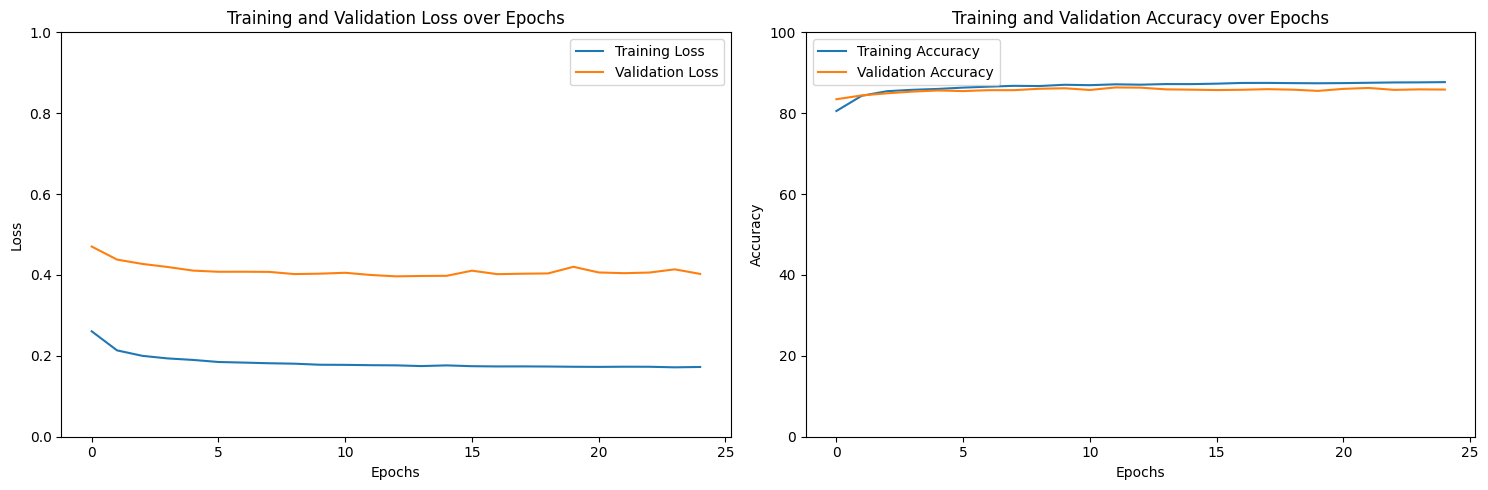

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()